In [66]:
# FIRST, SPECIFY DATASET AND REGRESSION DETAILS.

filepath    = "data.xlsx"                                   # EXCEL FILE PATH.
spreadsheet = "datasheet"                                   # SPREADSHEET NAME.
columnnames = ["Country", "t", "g", "u", "s", "h"]          # COLUMNS TO LOAD. MUST INCLUDE THE PANEL MEMBER ID AND TIME INDEX.
panelID     = "Country"                                     # PANEL MEMBER ID.
timeID      = "t"                                           # TIME INDEX.
endos       = ["g", "u" ,"s", "h"]                          # DESIRED SVAR MODEL RESTRICTION VARIABLE ORDER
lags        = 4                                             # DESIRED MODEL LAGLENGTH. DETERMINE THIS BEFOREHAND WITH SOMETHING LIKE AIC.
bootsteps   = 100                                           # DESIRED AMOUNT OF BOOTSTRAPPING ROUNDS FOR CONFIDENCE INTERVAL ESTIMATION.
irfperiods  = 25                                            # DESIRED LENGTH OF THE GENERATED IMPULE RESPONSE FUNCTIONS.

# THE PARAMETERS BELOW SPECIFY WHICH IMPULSE AND RESPONSE TO
# PLOT, WHETHER TO PLOT AN IRF OR A CIRF, AND SAVEFILE NAME.
# YOU CAN RESPECIFY THESE LATER SO THAT THE ENTIRE PROGRAM 
# DOES NOT HAVE TO RUN AGAIN TO VIEW OTHER PLOTS.
DPI             = 800                                       # PLOT RESOLUTION
plotimpulse     = 3                                         # IMPULSE VARIABLE  - USE POSITION ACCORDING TO VARIABLE ORDERING
plotresponse    = 1                                         # RESPONSE VARIABLE - USE POSITION ACCORDING TO VARIABLE ORDERING
irforcirf       = 1                                         # SET TO 0 FOR IRF AND SET TO 1 FOR CIRF
plotname        = "CIRF plot"                               # SPECIFY PLOT NAME FOR SAVING

# RUN ALL CELLS WHEN READY, OR JUST THE FINAL PLOTTING CELL IF 
# YOU HAVE ALREADY RUN THE MODEL AND WISH TO VIEW OTHER PLOTS.

In [67]:
# IMPORT NECESSARY LIBRARIES.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels as sm
from matplotlib import rc
import matplotlib.ticker as mtick
import random


In [68]:
# LOAD DATA AND SET PROGRAM PARAMETERS  

data = pd.read_excel(filepath, sheet_name=spreadsheet, usecols=columnnames)
groups = data.groupby(panelID)
panel = {key1: group for key1, group in groups}
members = panel.keys()
m = len(members)
t = int(data.shape[0]/m)
n = len(endos)
data = data.set_index([panelID,timeID])
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [69]:
# DEFINE FUNCTIONS

# Container for SVAR results
class ClassSVARresults:
        sigma   = 0
        chol    = 0
        cholv   = 0
        resids  = 0
        matC    = 0
        Bv      = 0
        matB    = 0
        D       = 0
        matA    = 0

#Reduced form LSDV VAR regression, takes full dataset, endogenous variables, and number of lags
def baseSVAR(data, regressands, lags):
    
    # Work on copy of dataset
    df = data.copy()

    # Create temporary containers
    olsresults  = dict.fromkeys(regressands)
    resids      = pd.DataFrame()
    coeffs      = pd.DataFrame()
    D           = pd.DataFrame()

    # Define number of endogenous variables
    n           = len(regressands)

    # Generates lags for the engodenous covariates
    for v in regressands:
        for l in range(1, lags+1):
            df[str(v)+"_"+str(l)] = df.groupby([panelID])[v].shift(l)
    laglist = df.columns.tolist()[len(regressands):]
    df = df.dropna()

    # Generate dummy variables for each panel member
    dummylist = []
    for i in members:
        # Prefixing dummies with 000 is a hacky way of grouping their coefficients for easier extraction of parameter estimates
        df["000dummy_"+str(i)] = 0                  
        dummylist.append(str("000dummy_"+str(i)))
        df.loc[i,"000dummy_"+str(i)] = 1

    # Container for SVAR results
    results = ClassSVARresults()

    # VAR regression
    for v in regressands:
        olsresults[v]   = sm.regression.linear_model.OLS(df.loc[:,v], df.loc[:,dummylist+laglist], hasconst=None).fit()
        coeffs[v]       = olsresults[v].params.tail(n*lags)
        D[v]            = olsresults[v].params[:m]
        resids[v]       = olsresults[v].resid
    results.resids = resids
    results.D = D

    # Construct coefficient matrix, matA
    A = []
    for i in range(lags):
        a = pd.DataFrame(index=regressands)
        for v in regressands:
            for l in range(lags):
                a.loc[v, str(regressands[l])+str(i+1)] = coeffs[v][i+l*lags]
        A.append(a)
    for i in range(len(A)):
        A[i] = np.array(A[i])
    results.matA = A

    # Construct the companion matrix, matC
    A = []
    n = len(regressands)
    for i in range(lags):
        a = pd.DataFrame(index=regressands)
        for v in regressands:
            for l in range(lags):
                a.loc[v, str(regressands[l])+str(i+1)] = coeffs[v][i+l*lags]
        A.append(a)
    c = np.zeros([lags*n,lags*n])
    for i in range(lags):
        c[0:n, i*n:i*n+n] = A[i]
    c[n:,0:n*lags-n] = np.identity(n*lags-n)
    results.matC = c

    # Compute the sigma matrix
    matsigma = pd.DataFrame(index=regressands)
    for i in regressands:
        for j in regressands:
            matsigma.loc[i,j] = np.dot(resids[i],resids[j])/(df.shape[0]-(lags*n)-m)
    results.sigma = matsigma

    # Compute the Choleski matrix and the extended Choleski matrix (used for obtaining IRFs togther with matC)
    chol = np.linalg.cholesky(matsigma)
    cholv = np.zeros([n*lags,n])
    cholv[:n,:n] = chol
    results.cholv = cholv
    results.chol = chol

    # Compute the B matrix and extended B matrix (used for obtaining IRFs togther with matC)
    chol_diag = np.zeros([n,n])
    for j in range(4):
        chol_diag[j][j] = chol[j][j]
    B = np.matmul(chol, np.linalg.inv(chol_diag))
    results.matB = B
    Bv = np.zeros([n*lags,n])
    Bv[:n,:n] = B
    results.Bv = Bv
    
    # Return all the necessary components for computing IRFs
    return results

# Computes IRFs and CIRFs from the companion and Choleski matrices, returning an ndarray of dimensions [IRFs/CIRFs, steps, n, n]
def makeIRFS(companion, gamma, steps):
    n = gamma.shape[1]
    C = np.zeros([steps,companion.shape[0], companion.shape[0]])
    results = np.ndarray([2, steps, n, n])
    C[0] = np.identity(companion.shape[0])
    for i in range(1, steps):
        C[i] = np.linalg.matrix_power(companion, i)

    IRFS = np.zeros([steps, n, n])                
    for i in range(steps):
        IRFS[i]= np.matmul(C[i],gamma)[:n, :]
    
    CIRFS = np.zeros([steps, n, n])               
    CIRFS[0] = IRFS[0]
    for i in range(1, steps):
        CIRFS[i] = IRFS[i]+CIRFS[i-1]

    results[0, :, :, :] = IRFS
    results[1, :, :, :] = CIRFS
    return results

# Takes data, endogenous variables, number of lags and IRF steps, returning an ndarray of dimensions [IRFs/CIRFs, steps, n, n]
def runmodel(data, regressands, lags, steps):
    SVARmodel = baseSVAR(data, regressands, lags)
    IRFS = makeIRFS(SVARmodel.matC, SVARmodel.Bv, steps)
    return IRFS

# Takes specification, lags, IRF steps, and number of bootstrap rounds for filesaving. 
def bootstrap(regressands, lags, irfsteps, bootrounds):
    periodlength = int(t-lags)
    n = len(regressands)

    SVARresults = baseSVAR(data, regressands, lags)
    bootresids = SVARresults.resids.copy()
    bootresids.loc[:,:] = 0
    bootdata = bootresids.copy()
    residrows = dict.fromkeys(members)
    bootresults = []

    for member in members:
        rowlist = []
        for index, rows in SVARresults.resids.loc[member].iterrows():
            list = rows
            rowlist.append(list)
        residrows[member] = rowlist

    for i in range(bootrounds):
        bootdata.loc[:,:] = 0
        for member in members:
            residlist_sample = random.choices(residrows[member], k=periodlength)
            for k in range(periodlength):
                for v in range(n):
                    bootresids.loc[member,regressands[v]].iloc[k] = residlist_sample[k][v]

        for member in members:
            for k in range(periodlength):
                tempseries = []
                for j in range(lags):
                    tempseries.append(np.matmul(SVARresults.matA[j],bootdata.loc[member].iloc[k-j-1]))
                tempsum = np.sum(tempseries, axis=0)
                bootdata.loc[member].iloc[k] = bootresids.loc[member].iloc[k] + SVARresults.D.loc["000dummy_" + str(member)] + tempsum

        bootresults.append(runmodel(bootdata, regressands, lags, irfsteps))
        print("                                             ", end = "\r")
        print("Round: " + str(i+1) + " of " + str(bootrounds), end = "\r")

    bootseries = np.zeros([bootrounds, 2, irfsteps, n, n])
    f = 0
    for res in bootresults:
        bootseries[f] = res
        f=f+1
    np.save("".join(regressands) + "_" + str(bootrounds) + ".npy", bootseries)


In [70]:
# RUN MODEL AND COMPUTE CONFIDENCE INTERVALS

# SVAR and bootstrapping
IRFSCIRFS = runmodel(data, endos, lags, irfperiods)
bootstrap(endos, lags, irfperiods, bootsteps)

# Computes Hall's Studentized confidence intervals 
bootirfs = np.load("".join(endos) + "_" + str(bootsteps) + ".npy")
qrt = np.zeros([bootsteps, 2, irfperiods, n, n])
CIs = np.zeros([2, 2, irfperiods, n, n])
for f in range(2):
    for p in range(1,irfperiods):
        for r in range(n):
            for c in range(n):
                qrt[:,f,p,r,c] = (bootirfs[:,f,p,r,c] - IRFSCIRFS[f,p,r,c])/np.std(bootirfs[:,f,p,r,c])
for f in range(2):
    for p in range(irfperiods):
        for r in range(n):
            for c in range(n):
                if p == 0:
                    CIs[0,f,p,r,c] = IRFSCIRFS[f,p,r,c]
                    CIs[1,f,p,r,c] = IRFSCIRFS[f,p,r,c]
                if p > 0:
                    CIs[0,f,p,r,c] = IRFSCIRFS[f,p,r,c] - np.percentile(qrt[:,f,p,r,c], 97.5)*np.std(bootirfs[:,f,p,r,c])
                    CIs[1,f,p,r,c] = IRFSCIRFS[f,p,r,c] - np.percentile(qrt[:,f,p,r,c], 2.5)*np.std(bootirfs[:,f,p,r,c])


# Combines estimates into single plot container
PLOTS = np.zeros([3, 2, irfperiods, n, n]) # [CI/actual/CI, irf/cirf, period, response, impulse]
PLOTS[0,:,:,:,:] = CIs[0]
PLOTS[1,:,:,:,:] = IRFSCIRFS
PLOTS[2,:,:,:,:] = CIs[1]

# Save to disk
np.save("".join(endos) + "_" + str(bootsteps) + "_PLOTS.npy", PLOTS)


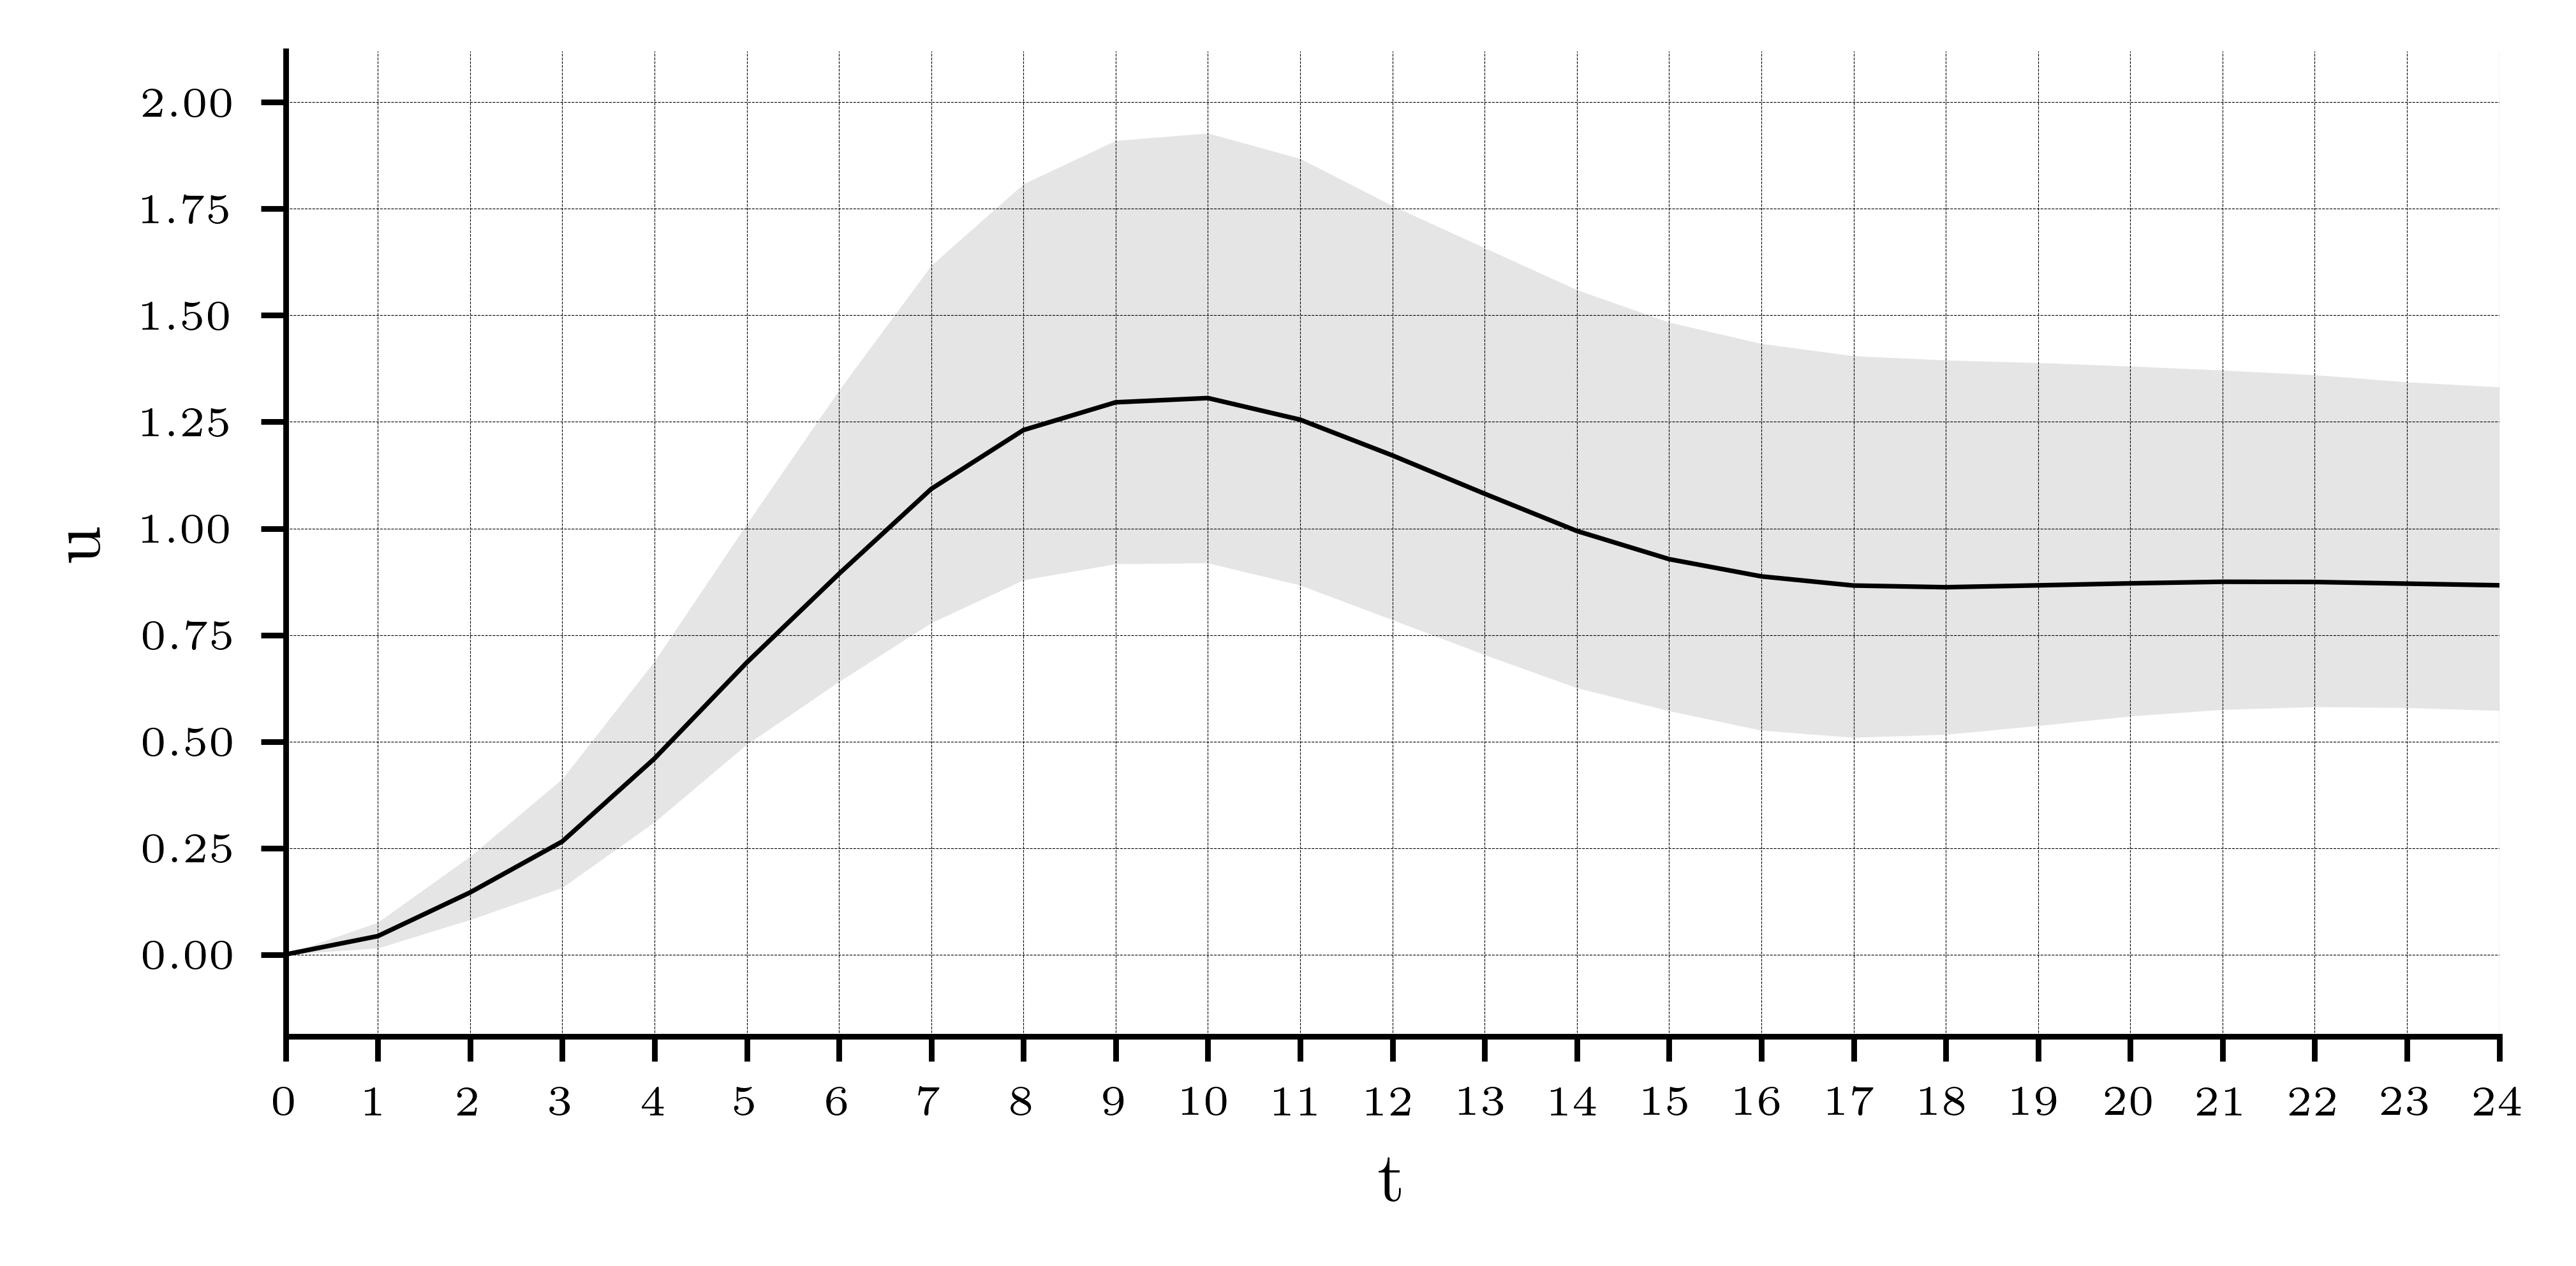

In [71]:
# DISPLAY AND SAVE PLOT

# Plot series
upper = PLOTS[2, irforcirf, :, plotresponse, plotimpulse]
lower = PLOTS[0, irforcirf, :, plotresponse, plotimpulse]
irf =   PLOTS[1, irforcirf, :, plotresponse, plotimpulse]

fig, ax = plt.subplots(figsize=(5, 10/4), dpi = DPI)
fig.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(visible=True, linewidth = 0.1, color = "black" , linestyle = "--")
ax.fill_between(range(25), lower, upper, color = "0.8", alpha = 0.5, linewidth = 0)
ax.plot(irf,color = "black", linewidth = 0.65)
ax.margins(0,0.1)
ax.locator_params(axis='y', nbins=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_tick_params(labelsize = 6)
ax.yaxis.set_tick_params(labelsize = 6)
ax.set_ylabel(endos[plotresponse], fontsize = 10)
ax.set_xlabel("t", fontsize = 10)
plt.savefig(plotname)